# Stock prediction using LSTM
This projects showcases performance of an LSTM model for stock prediction on Berkshire Hathaway and Microsoft share data.

There are various standard trading indicators used by investors to make decisions. Some standard trading indicators are:
* closing price
* hlc average (mean of high, low and closing share price)
* ohlc average (mean of open, high, low and closing share price)
etc...

In this project, I have chosen OHLC average as our trading indicator.

In [1]:
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf
from keras.layers import LSTM, Activation, Dense, Dropout
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
def get_ohlc_avg(symbol: str, period='3y'):
    data = yf.Ticker(symbol)
    historical_data = data.history(period=period)
    ohlc_avg = pd.DataFrame(historical_data.iloc[:, 0:4].mean(axis=1), columns=['OHLC_avg'])
#     ohlc_avg = historical_data.iloc[:, 3:4]
    return ohlc_avg

stock_symbol = 'BRK-A'
ohlc_avg = get_ohlc_avg(stock_symbol, '3y')
ohlc_avg.head()

,OHLC_avg
Date,
2018-05-08,294817.50
2018-05-09,297485.25
2018-05-10,300508.75
2018-05-11,300240.00
2018-05-14,299257.50


## Splitting the data into testing and training datasets
Testing dataset: Last 90 days (~60 trading days)
Training dataset: Last 3 years - Last 90 days

In [3]:
def split_data(data: pd.DataFrame, split_parameter='90days'):
    testing_dataframe = ohlc_avg[ohlc_avg.index > datetime.utcnow() - pd.to_timedelta('90days')]
    training_dataframe = ohlc_avg[ohlc_avg.index < testing_dataframe.index[0]]
    print('training dataframe:', training_dataframe.shape)
    print('testing dataframe:', testing_dataframe.shape)
    return training_dataframe, testing_dataframe

training_dataframe, testing_dataframe = split_data(ohlc_avg)

training dataframe: (694, 1)
testing dataframe: (62, 1)


In [4]:
def get_data_scaler(data):
    transformer = MinMaxScaler(feature_range = (0, 1))
    transformer.fit_transform(training_dataset)
    return transformer

    
training_dataset = training_dataframe.values
transformer = get_data_scaler(training_dataset)
training_dataset_scaled = transformer.transform(training_dataset)

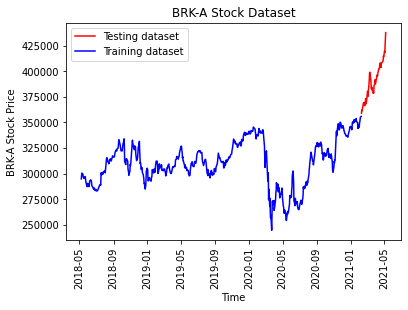

In [5]:
def plot_training_testing_distribution(symbol, training_df, testing_df):
    plt.plot(testing_df, color = 'red', label = 'Testing dataset')
    plt.plot(training_df, color = 'blue', label = 'Training dataset')
    plt.title('{} Stock Dataset'.format(symbol))
    plt.xlabel('Time')
    plt.ylabel('{} Stock Price'.format(symbol))
    plt.legend()
    plt.xticks(rotation='vertical')
    plt.show()

plot_training_testing_distribution(stock_symbol, training_dataframe, testing_dataframe)

### Creating data with timesteps
Here we are preparing the input for LSTM model such that we will be taking the data from last 60 trading days to predict the next trading day's mean OHLC share value.

In [6]:
def prepare_data_with_timesteps(data, lookback_timesteps: int):
    """
    Here we are preparing the input for LSTM model such that 
    we will be curating data with timesteps
    """
    X_data = []
    y_data = []

    for i in range(lookback_timesteps, len(data)):
        X_data.append(data[i-lookback_timesteps:i, :])
        y_data.append(data[i, 0])

    return np.array(X_data), np.array(y_data)

lookback = 60
X_train, y_train = prepare_data_with_timesteps(training_dataset_scaled, lookback)

## Creating and fitting the LSTM model

In [12]:
def create_and_fit_LSTM(X_train_data, y_train_data, epochs=100, batch_size=32):
    stock_prediction_model = Sequential()
    stock_prediction_model.add(LSTM(units = 50,return_sequences = True, input_shape = (X_train_data.shape[1], 1)))
    stock_prediction_model.add(Dropout(0.2))
    stock_prediction_model.add(LSTM(units = 50,return_sequences = True))
    stock_prediction_model.add(Dropout(0.2))
    stock_prediction_model.add(LSTM(units = 50,return_sequences = True))
    stock_prediction_model.add(Dropout(0.2))
    stock_prediction_model.add(LSTM(units = 50))
    stock_prediction_model.add(Dropout(0.2))
    stock_prediction_model.add(Dense(units = 1))
    stock_prediction_model.compile(optimizer = 'adam', loss = 'mean_squared_error')


    # fit the model
    stock_prediction_model.fit(X_train_data, y_train_data, epochs = epochs, batch_size = batch_size)
    
    return stock_prediction_model

stock_prediction_model = create_and_fit_LSTM(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
20/20 [==============================] - 8s 63ms/step - loss: 0.1599
Epoch 2/100
20/20 [==============================] - 1s 62ms/step - loss: 0.0281
Epoch 3/100
20/20 [==============================] - 1s 61ms/step - loss: 0.0217
Epoch 4/100
20/20 [==============================] - 1s 53ms/step - loss: 0.0198
Epoch 5/100
20/20 [==============================] - 1s 53ms/step - loss: 0.0201
Epoch 6/100
20/20 [==============================] - 1s 53ms/step - loss: 0.0144
Epoch 7/100
20/20 [==============================] - 1s 53ms/step - loss: 0.0150
Epoch 8/100
20/20 [==============================] - 1s 54ms/step - loss: 0.0159
Epoch 9/100
20/20 [==============================] - 1s 53ms/step - loss: 0.0133
Epoch 10/100
20/20 [==============================] - 1s 53ms/step - loss: 0.0147
Epoch 11/100
20/20 [==============================] - 1s 53ms/step - loss: 0.0116
Epoch 12/100
20/20 [==============================] - 1s 53ms/step - loss: 0.0121
Epoch 13/100
20/20 [=====

## Stock prediction using LSTM model and trading suggestion

### Trading sugggestion
This is a simplistic trading suggestion login which takes into consideration the average share price to suggest whether it is favourable to buy, sell or hold the stock. In our code we have taken the average share price of last 30 trading days to suggest a favourable action.

In [13]:
def suggest_favourable_action(historical_ohlc_avg, next_day_prediction):
    mean_of_historical_ohlc_avg = historical_ohlc_avg.mean()[0]
    if next_day_prediction < mean_of_historical_ohlc_avg:
        return 'buy'
    elif next_day_prediction > mean_of_historical_ohlc_avg:
        return 'sell'
    else:
        return 'hold'

### Stock prediction
We will use the LSTM model on our test dataset to predict the share price.

In [14]:
def predict_stock_prices(ohlc_avg_data, testing_dataframe_data, model, scalar_transformer, trading_window=30):
    """
    We will use the LSTM model on our test dataset to predict the 
    share price and suggest a favourable action.
    
    Args:
        ohlc_avg_data: complete dataset with OHLC average values
        testing_dataframe_data: testing dataset
        model: trained LSTM model
        scalar_transformer: Scalar transformer for normalizing and denormalizing the data
        trading_window: Number of days you want to consider to calcuate
                        average ohlc data to compare with the next prediction
    
    Returns:
        predicted_stock_price (list): predicted ohlc stock price
    """
    real_stock_price = testing_dataframe_data.iloc[:, 0:1].values
    predicted_stock_price = []
    predicted_stock_price_scaled = []

    inputs = ohlc_avg_data[len(ohlc_avg_data) - len(testing_dataframe_data) - lookback:].values
    inputs = scalar_transformer.transform(inputs)

    correct = wrong = total = 0
    for i in range(lookback, len(inputs)):
        next_day_input = inputs[i-lookback:i, :]
        next_day_input = next_day_input.reshape(1, -1, 1)
        next_day_predicted_stock_price = model.predict(next_day_input)
        predicted_stock_price_scaled.append(next_day_predicted_stock_price[0][0])
        next_day_predicted_stock_price = scalar_transformer.inverse_transform(next_day_predicted_stock_price)
        predicted_stock_price.append(next_day_predicted_stock_price[0][0])
        prediction = suggest_favourable_action(ohlc_avg_data[len(training_dataframe) + i - lookback - trading_window:len(training_dataframe) + i - lookback], next_day_predicted_stock_price[0][0])
        print('Prediction: Tomorrow (utc:{}) it is more favourable to {}'.format(str(testing_dataframe_data.index[i-60].date()), prediction))
        real = suggest_favourable_action(ohlc_avg_data[len(training_dataframe) + i - lookback - trading_window:len(training_dataframe) + i - lookback], real_stock_price[i-lookback])
        if prediction != real:
            wrong += 1
        else:
            correct += 1
        total += 1
            
    print("\n\nCorrect predictions:", correct)
    print("Wrong predictions:", wrong)
    print("Correct predictions percentage: {}%\n".format(round(correct*100/total, 2)))
    
    print("RMSE (range: 0 to 1):", mean_squared_error(inputs[60:], predicted_stock_price_scaled, squared=False))
    
    return predicted_stock_price

predicted_ohlc_prices = predict_stock_prices(ohlc_avg, testing_dataframe, stock_prediction_model, transformer)

Prediction: Tomorrow (utc:2021-02-09) it is more favourable to sell
Prediction: Tomorrow (utc:2021-02-10) it is more favourable to sell
Prediction: Tomorrow (utc:2021-02-11) it is more favourable to sell
Prediction: Tomorrow (utc:2021-02-12) it is more favourable to sell
Prediction: Tomorrow (utc:2021-02-16) it is more favourable to sell
Prediction: Tomorrow (utc:2021-02-17) it is more favourable to sell
Prediction: Tomorrow (utc:2021-02-18) it is more favourable to sell
Prediction: Tomorrow (utc:2021-02-19) it is more favourable to sell
Prediction: Tomorrow (utc:2021-02-22) it is more favourable to sell
Prediction: Tomorrow (utc:2021-02-23) it is more favourable to sell
Prediction: Tomorrow (utc:2021-02-24) it is more favourable to sell
Prediction: Tomorrow (utc:2021-02-25) it is more favourable to sell
Prediction: Tomorrow (utc:2021-02-26) it is more favourable to sell
Prediction: Tomorrow (utc:2021-03-01) it is more favourable to sell
Prediction: Tomorrow (utc:2021-03-02) it is more

### Plot the prediction vs real share values

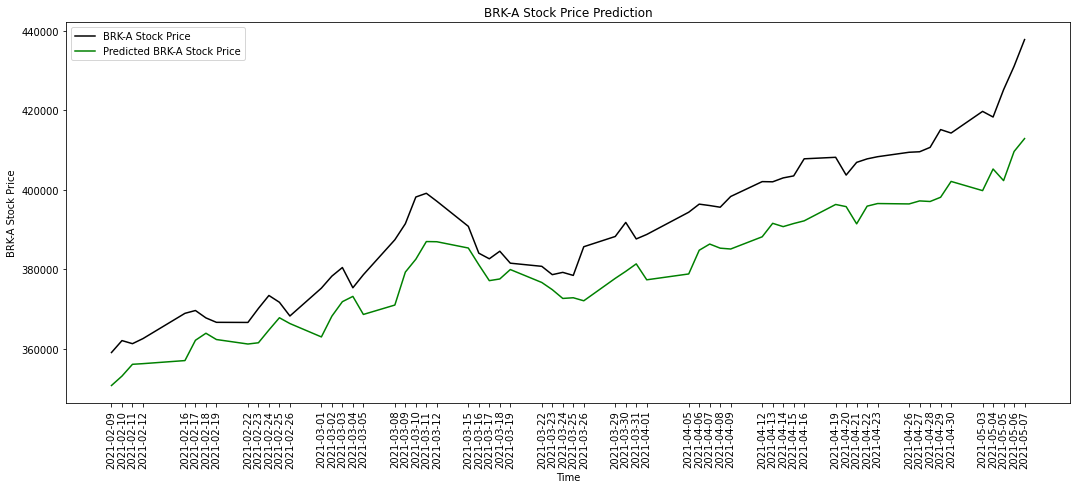

In [15]:
def prediction_vs_real(symbol: str, real_values, predicted_values):
    plt.figure(figsize = (18,7))
    plt.plot(real_values, color = 'black', label = '{} Stock Price'.format(stock_symbol))
    plt.plot(predicted_values, color = 'green', label = 'Predicted {} Stock Price'.format((stock_symbol)))
    plt.xticks(predicted_values.index.to_pydatetime())
    plt.title('{} Stock Price Prediction'.format(stock_symbol))
    plt.xlabel('Time')
    plt.ylabel('{} Stock Price'.format(stock_symbol))
    plt.legend()
    plt.xticks(rotation='vertical')
    plt.show()

predicted_stock_price_dataframe = pd.DataFrame(data=predicted_ohlc_prices,
                                               index=testing_dataframe.index,
                                               columns=testing_dataframe.columns)
prediction_vs_real(stock_symbol, testing_dataframe, predicted_stock_price_dataframe)